## Imports

In [2]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import sparse_categorical_crossentropy

from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,GlobalAveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
import itertools

from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

print ('Library loaded')

Library loaded


In [3]:
inp = '../input/skin-cancer-mnist-ham10000/'
os.listdir(inp)

['hmnist_8_8_RGB.csv',
 'hmnist_28_28_RGB.csv',
 'HAM10000_images_part_1',
 'ham10000_images_part_1',
 'hmnist_8_8_L.csv',
 'HAM10000_images_part_2',
 'ham10000_images_part_2',
 'hmnist_28_28_L.csv',
 'HAM10000_metadata.csv']

### Create the directory structure

In these folders we will store the images that will later be fed to the Keras generators.

In [4]:
folders_to_create = ["HAM10000_224new"]


def create_folders(folders):
    for folder in folders:
        folder_path = os.path.join(folder)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
            print(f"Folder '{folder}' sudah dibuat.")
        else:
            print(f"Folder '{folder}' sudah ada.")


create_folders(folders_to_create)

Folder 'HAM10000_224new' sudah dibuat.


### Create Train and Val Sets

In [5]:
base = 'HAM10000_224new'

data_pd = pd.read_csv(inp+'HAM10000_metadata.csv')
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:
train_dir = os.path.join(base, "train_dir")
test_dir = os.path.join(base, "test_dir")

In [7]:
df_count = data_pd.groupby('lesion_id').count()
df_count.head()

,image_id,dx,dx_type,age,sex,localization
lesion_id,,,,,,
HAM_0000000,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1


In [8]:
df_count = df_count[df_count['dx'] == 1]
df_count.reset_index(inplace=True)

In [9]:
#Memeriksa apakah terdapat gambar yang memiliki duplikat
def duplicates(x):
    unique = set(df_count['lesion_id'])
    if x in unique:
        return 'no'
    else:
        return 'duplicates'

data_pd['is_duplicate'] = data_pd['lesion_id'].apply(duplicates)
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates


In [10]:
df_count = data_pd[data_pd['is_duplicate'] == 'no']

data_pd['is_duplicate'].value_counts()

no            5514
duplicates    4501
Name: is_duplicate, dtype: int64

In [11]:
#Melihat gambar-gambar yang terduplikat
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

data_pd.dx=data_pd.dx.astype('category',copy=True)
data_pd['label']=data_pd.dx.cat.codes # Convert the labels to numbers
data_pd['lesion_type']= data_pd.dx.map(lesion_type_dict)
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate,label,lesion_type
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates,2,Benign keratosis


In [12]:
#Total class count
class_counts = data_pd['lesion_type'].value_counts()
print(class_counts)

Melanocytic nevi        6705
Melanoma                1113
Benign keratosis        1099
Basal cell carcinoma     514
Actinic keratoses        327
Vascular lesions         142
Dermatofibroma           115
Name: lesion_type, dtype: int64


In [13]:
# #Split test data 20%
train, test_df = train_test_split(df_count, test_size=0.20, stratify=df_count['dx'])


In [14]:
#Memeriksa tiap gambar masuk kedalam jenis train atau test
def identify_trainOrtest(x):
    test_data = set(test_df['image_id'])
    if str(x) in test_data:
        return 'test'
    else:
        return 'train'

# train_df
data_pd['train_test_split'] = data_pd['image_id'].apply(identify_trainOrtest)
train_df = data_pd[data_pd['train_test_split'] == 'train']
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate,label,lesion_type,train_test_split
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates,2,Benign keratosis,train


In [15]:
test_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
5967,HAM_0002819,ISIC_0024467,nv,follow_up,40.0,male,lower extremity,no
2801,HAM_0004480,ISIC_0032290,bcc,histo,80.0,male,face,no
2922,HAM_0000915,ISIC_0030339,bcc,histo,75.0,female,lower extremity,no
502,HAM_0005728,ISIC_0025781,bkl,histo,75.0,male,upper extremity,no
9744,HAM_0002472,ISIC_0025696,akiec,histo,60.0,male,face,no


In [16]:
#membagi kelas
train_list = list(train_df['image_id'])
test_list = list(test_df['image_id'])

#Total data untuk train dan test
print(len(train_list))
print(len(test_list))

8912
1103


In [17]:
data_pd.set_index('image_id', inplace=True)

In [18]:
#membuat berkas train
os.mkdir(train_dir)
os.mkdir(test_dir)

In [19]:
classname = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
for i in classname:
  directory1=train_dir+'/'+i
  directory2=test_dir+'/'+i
  os.mkdir(directory1)
  os.mkdir(directory2)

folder_1 = os.listdir(inp+'ham10000_images_part_1')
folder_2 = os.listdir(inp+'ham10000_images_part_2')

# memasukkan gambar ke train set
for image in train_list:
    fname = image + '.jpg'
    label = data_pd.loc[image, 'dx']

    if fname in folder_1:
        src = os.path.join(inp+'ham10000_images_part_1', fname)
        dst = os.path.join(train_dir, label, fname)
        
        shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join(inp+'ham10000_images_part_2', fname)
        dst = os.path.join(train_dir, label, fname)
        
        shutil.copyfile(src, dst)

#  memasukkan gambar ke test set
for image in test_list:
    fname = image + '.jpg'
    label = data_pd.loc[image, 'dx']

    if fname in folder_1:
        src = os.path.join(inp+'ham10000_images_part_1', fname)
        dst = os.path.join(test_dir, label, fname)
        
        shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join(inp+'ham10000_images_part_2', fname)
        dst = os.path.join(test_dir, label, fname)
        
        shutil.copyfile(src, dst)

# menghitung total gambar tiap kelas train set
train_class_counts = train_df['lesion_type'].value_counts()
print("Train File Class Counts:")
print(train_class_counts)

Train File Class Counts:
Melanocytic nevi        5822
Melanoma                1067
Benign keratosis        1011
Basal cell carcinoma     479
Actinic keratoses        297
Vascular lesions         129
Dermatofibroma           107
Name: lesion_type, dtype: int64


In [20]:
# Image Augmentation

classname = ["akiec", "bcc", "bkl", "df", "mel", "nv", "vasc"]
for img_class in classname:
    aug_dir = os.path.join(base, "aug_dir")
    os.mkdir(aug_dir)
    img_dir = os.path.join(aug_dir, "img_dir")
    os.mkdir(img_dir)

    img_list = os.listdir(
        os.path.join(base, "train_dir", img_class)
    )
    for file_name in img_list:
        source = os.path.join(
            base, "train_dir", img_class, file_name
        )
        target = os.path.join(img_dir, file_name)
        shutil.copyfile(source, target)

    source_path = aug_dir
    save_path = os.path.join(base, "train_dir", img_class)
    batch_size = 50

    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.05,
    )

    aug_datagen = datagen.flow_from_directory(
        source_path,
        save_to_dir=save_path,
        save_format="jpg",
        target_size=(224, 224),
        batch_size=batch_size,
    )
    ###Dataset Balance
    aug_images = 6000

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((aug_images - num_files) / batch_size))

    for i in range(0, num_batches):
        images, labels = next(aug_datagen)

    # hapus temporary directory
    shutil.rmtree(aug_dir)

Found 297 images belonging to 1 classes.
Found 479 images belonging to 1 classes.
Found 1011 images belonging to 1 classes.
Found 107 images belonging to 1 classes.
Found 1067 images belonging to 1 classes.
Found 5822 images belonging to 1 classes.
Found 129 images belonging to 1 classes.


In [21]:
# Original lesion type dictionary
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Assuming data_pd['label'] contains numerical codes obtained from data_pd['dx']
numerical_to_lesion_type = {code: lesion_type for code, lesion_type in zip(data_pd['label'], data_pd['lesion_type'])}

# Print the mapping of numerical codes to lesion types
for code, lesion_type in numerical_to_lesion_type.items():
    print(f"Label {code} corresponds to lesion type: {lesion_type}")


Label 2 corresponds to lesion type: Benign keratosis 
Label 5 corresponds to lesion type: Melanocytic nevi
Label 3 corresponds to lesion type: Dermatofibroma
Label 4 corresponds to lesion type: Melanoma
Label 6 corresponds to lesion type: Vascular lesions
Label 1 corresponds to lesion type: Basal cell carcinoma
Label 0 corresponds to lesion type: Actinic keratoses


In [22]:
#menghitung total kelas setelah augmentasi pada train set
def count_images_per_class(directory):
    class_counts = {}

    for img_class in os.listdir(directory):
        class_path = os.path.join(directory, img_class)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[img_class] = num_images

    return class_counts


augmented_train_dir = os.path.join(base, "train_dir")

augmented_class_counts = count_images_per_class(augmented_train_dir)

print("Banyak gambar per kelas pada train_df setelah augmentasi:")
for img_class, count in augmented_class_counts.items():
    print(f"{img_class}: {count} images")

Banyak gambar per kelas pada train_df setelah augmentasi:
mel: 5885 images
vasc: 5210 images
df: 4330 images
bkl: 5855 images
bcc: 5798 images
akiec: 5990 images
nv: 6022 images


In [23]:
# melihat banyaknya total gambar tiap kelas
test_class_counts = test_df["dx"].value_counts()
print("Banyak gambar per kelas pada test_df:")
print(test_class_counts)

Banyak gambar per kelas pada test_df:
nv       883
bkl       88
mel       46
bcc       35
akiec     30
vasc      13
df         8
Name: dx, dtype: int64


### Training Model

In [24]:
train_path = '/kaggle/working/HAM10000_224new/train_dir'
test_path = '/kaggle/working/HAM10000_224new/test_dir'

batch_size = 32

image_size = 224

In [25]:
# #inception

batch_size = 32
image_size = 224

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
# Create an instance of the inceptionv3 model
model = InceptionV3(weights='imagenet', include_top=False)

# Create an ImageDataGenerator with the preprocess_input function
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=False)


87924736/87910968 [==============================] - 0s 0us/step
Found 39090 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.


In [26]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

base_model = tf.keras.applications.InceptionV3(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model.layers:
    layer.trainable = False

# Fine-tune the last few layers
for layer in base_model.layers[-2:]:
    layer.trainable = True

In [27]:
#inception
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(7, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization_188 (Bat (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization_189 (Bat (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [28]:
# # We need to choose how many layers we actually want to be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

In [29]:
model.compile(
    optimizer="Adam",
    loss="categorical_crossentropy",
    metrics=["acc"],
)

In [30]:
#efficientnet
checkpoint = ModelCheckpoint(
    filepath="inception.hdf5",
    monitor="val_acc",
    save_best_only=True,
    verbose=1,
    mode="max",
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=0.00001,
)
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

In [31]:
history = model.fit(
    train_batches,
    steps_per_epoch=(len(train_df) // batch_size),
    epochs=15,
    verbose=1,
    validation_data=test_batches,
    validation_steps=(len(test_df) // batch_size),
    callbacks=[checkpoint, reduce_lr, early_stopping],
)

Epoch 1/15
278/278 [==============================] - 52s 147ms/step - loss: 1.5929 - acc: 0.4871 - val_loss: 0.5317 - val_acc: 0.8281

Epoch 00001: val_acc improved from -inf to 0.82812, saving model to inception.hdf5
Epoch 2/15
278/278 [==============================] - 39s 141ms/step - loss: 1.1897 - acc: 0.5682 - val_loss: 0.4751 - val_acc: 0.8438

Epoch 00002: val_acc improved from 0.82812 to 0.84375, saving model to inception.hdf5
Epoch 3/15
278/278 [==============================] - 40s 142ms/step - loss: 1.0540 - acc: 0.6061 - val_loss: 0.4822 - val_acc: 0.8410

Epoch 00003: val_acc did not improve from 0.84375
Epoch 4/15
278/278 [==============================] - 39s 140ms/step - loss: 1.0279 - acc: 0.6192 - val_loss: 0.4548 - val_acc: 0.8465

Epoch 00004: val_acc improved from 0.84375 to 0.84651, saving model to inception.hdf5
Epoch 5/15
278/278 [==============================] - 39s 140ms/step - loss: 0.9845 - acc: 0.6295 - val_loss: 0.4550 - val_acc: 0.8511

Epoch 00005: va

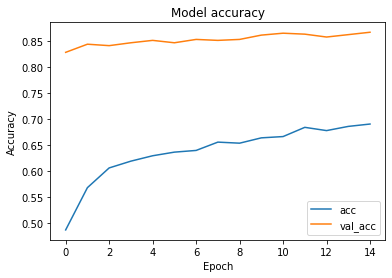

In [32]:
# plot graph accuracy
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["acc", "val_acc"], loc="lower right")
plt.show()

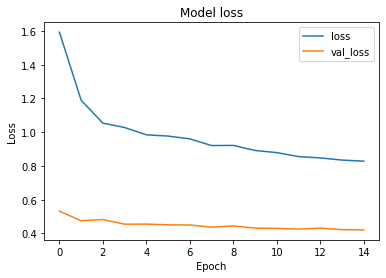

In [33]:
# plot graph loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss", "val_loss"], loc="upper right")
plt.show()

In [34]:
# model.save("efficient.hdf5")
model.save("inception.hdf5")

In [35]:
train_score = model.evaluate(train_batches, verbose=1)
test_score = model.evaluate(test_batches, verbose=1)

print("Train loss: ", train_score[0])
print("Train acc: ", train_score[1])
print("-" * 75)
print("Test loss: ", test_score[0])
print("Test acc: ", test_score[1])

35/35 [==============================] - 10s 295ms/step - loss: 0.4335 - acc: 0.8649
Train loss:  0.6145830750465393
Train acc:  0.7843949794769287
---------------------------------------------------------------------------
Test loss:  0.4335029423236847
Test acc:  0.8649138808250427


In [36]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


34/34 [==============================] - 11s 289ms/step

Classification Report:
               precision    recall  f1-score   support

       akiec    0.56250   0.30000   0.39130        30
         bcc    0.61111   0.62857   0.61972        35
         bkl    0.61644   0.51136   0.55901        88
          df    0.66667   0.25000   0.36364         8
         mel    0.32432   0.26087   0.28916        46
          nv    0.92333   0.96829   0.94527       883
        vasc    0.75000   0.69231   0.72000        13

    accuracy                        0.86491      1103
   macro avg    0.63634   0.51591   0.55544      1103
weighted avg    0.85024   0.86491   0.85482      1103



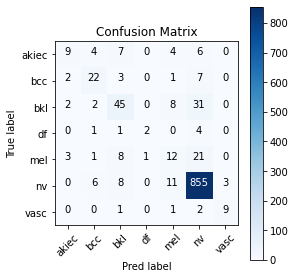

In [37]:
true_labels = test_batches.classes
model.load_weights("inception.hdf5")

predictions = model.predict(test_batches, steps=len(test_df) / batch_size, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(4, 4))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

# # We need these to plot the confusion matrix.
# test_labels

In [38]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

# # Print the label associated with each class
# test_batches.class_indices

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


Found 39090 images belonging to 7 classes.
1222/1222 [==============================] - 125s 102ms/step

Training Classification Report:
               precision    recall  f1-score   support

       akiec    0.73772   0.75693   0.74720      5990
         bcc    0.70839   0.83253   0.76546      5798
         bkl    0.68553   0.53390   0.60029      5855
          df    0.87272   0.89469   0.88357      4330
         mel    0.70899   0.63093   0.66769      5885
          nv    0.84059   0.91415   0.87583      6022
        vasc    0.95098   0.97562   0.96315      5210

    accuracy                        0.78439     39090
   macro avg    0.78642   0.79125   0.78617     39090
weighted avg    0.78045   0.78439   0.77964     39090



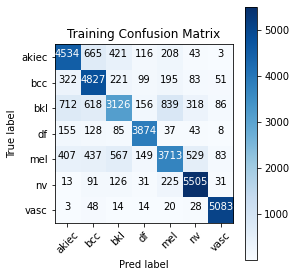

In [39]:
# Create a generator for the entire training set
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

# Calculate the number of steps needed to cover the entire training set
num_train_steps = len(train_all_batches)

# Predict labels for the entire training set
train_predictions = model.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

# Compute and print the classification report and confusion matrix
train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)
# print("\nTraining Confusion Matrix:\n", train_conf_matrix)

# Plot
plt.figure(figsize=(4, 4))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()
# # make a prediction
# predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)

## user prediction

In [42]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np
from tensorflow.keras.models import load_model
def predict_image_class(image_path):
    model = load_model('inception.hdf5')

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make prediction
    predictions =np.argmax(model.predict(img_array), axis=1)
    
    print(f"the image belongs to {[predictions[0]]}")

# Example usage
image_path = r"/kaggle/working/HAM10000_224new/test_dir/bcc/ISIC_0031298.jpg"
predict_image_class(image_path)

the image belongs to [1]


In [ ]:
# Label 2 corresponds to lesion type: Benign keratosis 
# Label 5 corresponds to lesion type: Melanocytic nevi
# Label 3 corresponds to lesion type: Dermatofibroma
# Label 4 corresponds to lesion type: Melanoma
# Label 6 corresponds to lesion type: Vascular lesions
# Label 1 corresponds to lesion type: Basal cell carcinoma
# Label 0 corresponds to lesion type: Actinic keratoses

In [50]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model, Model

def get_activations(model, layer_name, img):
    # Create a model that outputs the activations of the desired layer
    activation_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    # Preprocess the image
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Get the activations
    activations = activation_model.predict(x)

    return activations

def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if 'conv' in layer.name:
            return layer.name
    return None

def predict_image_class_with_activations(image_path, model_path):
    # Load the pre-trained model
    model = load_model(model_path)

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))

    # Get the predictions
    predictions = model.predict(np.expand_dims(img, axis=0))

    # Get the last convolutional layer before global average pooling
    last_conv_layer_name = find_last_conv_layer(model)
    if last_conv_layer_name is None:
        raise ValueError("No Conv2D layer found in the model.")

    # Get the activations of the last convolutional layer before global average pooling
    activations = get_activations(model, last_conv_layer_name, img)

    return predictions, activations

# Example usage
image_path = r"/kaggle/working/HAM10000_224new/test_dir/bcc/ISIC_0031298.jpg"
model_path = 'inception.hdf5'
predictions, activations = predict_image_class_with_activations(image_path, model_path)
print(f"The predicted class index is: {np.argmax(predictions)}")
print(f"The activations shape is: {activations.shape}")

# Visualize the activations
plt.imshow(activations[0, :, :, 0], cmap='viridis')  # Visualize the activations of the first channel
plt.colorbar()
plt.show()


ValueError: No Conv2D layer found in the model.

<!-- Label 2 corresponds to lesion type: Benign keratosis 
Label 5 corresponds to lesion type: Melanocytic nevi
Label 3 corresponds to lesion type: Dermatofibroma
Label 4 corresponds to lesion type: Melanoma
Label 6 corresponds to lesion type: Vascular lesions
Label 1 corresponds to lesion type: Basal cell carcinoma
Label 0 corresponds to lesion type: Actinic keratoses -->